<b>categorical variable</b>은 제한된 수를 사용한다.
# Three Approaches
### 1) Drop categorical Variables
범주형 변수를 처리하는 가장 쉬운 방법은 데이터 집합에서 변수를 제거하는것이다. 이 접근 방식은 열에 유용한 정보가 없을 때만 잘 작동한다.
### 2) Ordinal Encoding
Ordinal Encoding은 각각 다른 값을 할당하는 것이다.
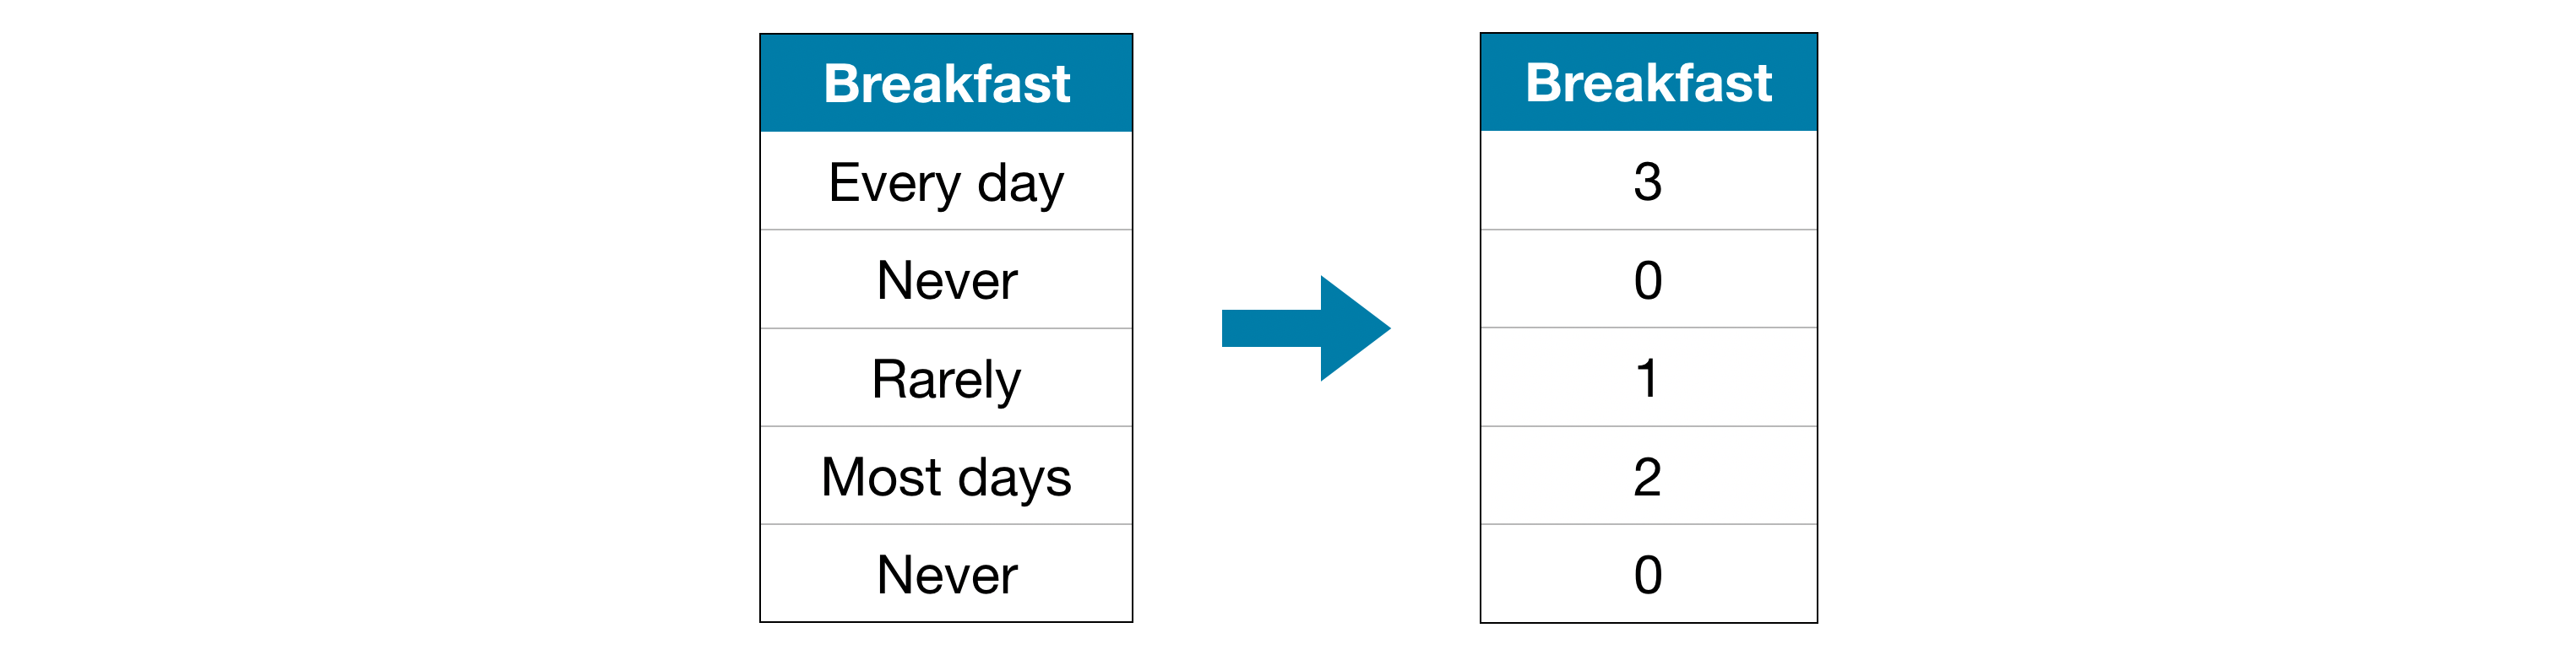
이 접근법은 범주의 순서를 가정한다. <br>
"Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).
### 3) One-Hot Encoding
one-hot Encoding은 원본 데이터에서 가능한 각 값을 나타내는 새 열을 만든다.
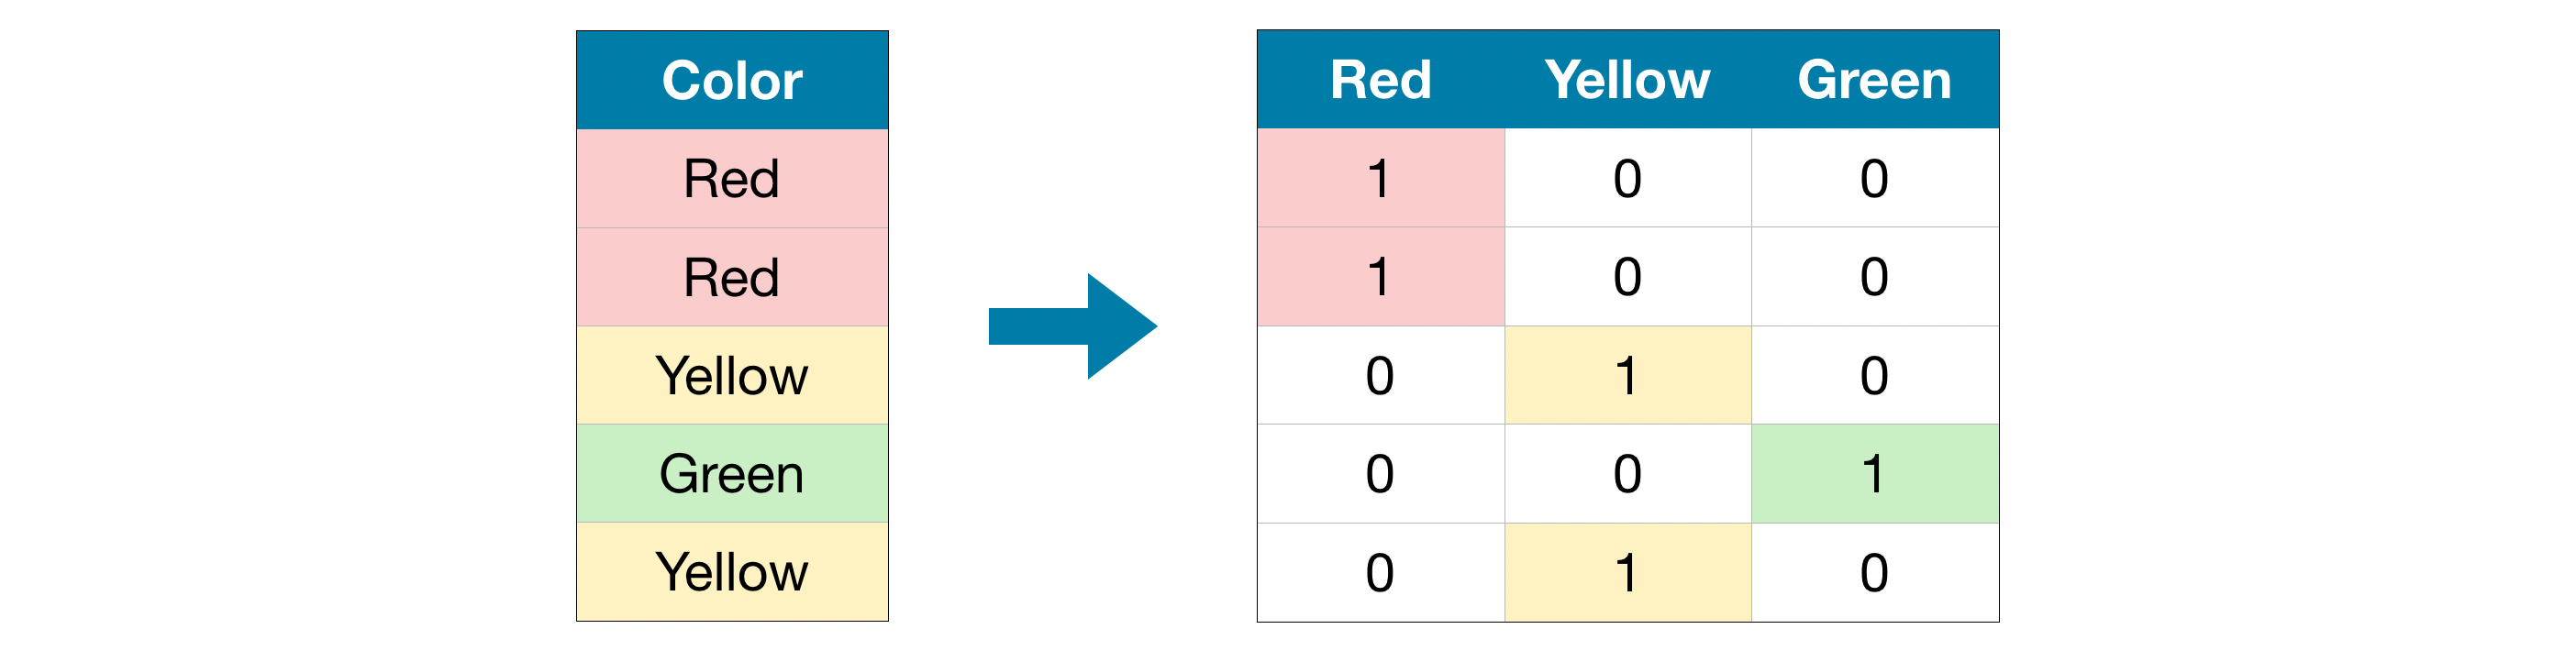
범주형 데이터에 명확한 순서가 없는 경우 잘 작동한다고 예상할 수 있다. 내적 순위가 없는 범주형 변수를 <b>nominal variables</b>이라고 한다.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

/Users/hongjin-u/opt/anaconda3/envs/Pytorch/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [3]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


In [4]:
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Score from Approach 1 (Drop Categorical Variables)
```select_dtypes()``` 메서드로 ```object``` columns을 drop한다.

In [12]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
175703.48185157913


### Score from Approach 2 (Ordinal Encoding)
Scikit-learn에는 ordinal encodings을 할 수 있는 ```OrdinalEncoder``` 클래스가 있다.<br>
범주형 변수를 루핑하고 ordinal encoder를 각 column에 별도로 적용한다.

In [13]:
from sklearn.preprocessing import OrdinalEncoder

label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):")
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
165936.40548390493


### Score from Approach 3 (One-Hot Encoding)
scikit-learn의 ```OneHotEncoder``` 클래스를 사용해 one-hot encoding을 한다. 여기는 여러 파라미터들이 있다.
<br>
- ```handle_unkown='ignore'```를 설정하면 validation data에 training data에 표시되지 않은 클래스가 포함되어 있을 때의 오류를 방지할 수 있다.
- ```sparse=False```를 설정하면 인코딩된 열이 sparse matrix대신 numpy array로 반환이 된다.

In [17]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))


OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE from Approach 3 (One-Hot Encoding):")
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
166089.4893009678


In [18]:
1e4

10000.0